# Lesson 22: unsupervised learning demonstration

This notebook demonstrates key concepts and tools for training unsupervised models.

1. Clustering
    - Kmeans
    - Hierarchical
    - DBSCAN
    - Clustering evaluation
    - Determining cluster number

2. Dimensionality reduction
    - PCA
    - Feature Agglomeration
    - t-SNE

3. Anomaly detection
4. Association rule learning


## Notebook set up

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from scipy.cluster.hierarchy import dendrogram, linkage

### Dataset

In [2]:
# Number of clusters
n_clusters = 3

# Generate synthetic dataset
data = make_blobs(
    n_samples=1000,
    n_features=2,
    centers=n_clusters,
    cluster_std=0.6,
    random_state=0
)

# Create dataframe with feature columns
df = pd.DataFrame(data[0], columns=[f'feature_{i}' for i in range(data[0].shape[1])])

# Standard scale the features
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,feature_0,feature_1
0,-0.972185,0.046031
1,0.652719,0.999023
2,-1.227944,0.217025
3,-1.083584,0.128545
4,-1.608505,-0.250835


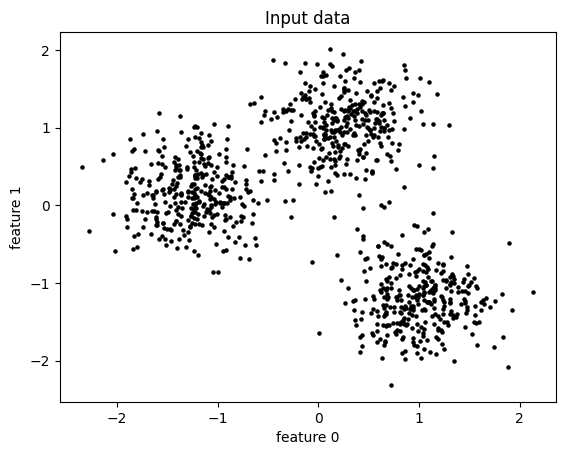

In [3]:
plt.title('Input data')
plt.scatter(df['feature_0'], df['feature_1'], s=5, c='black')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

## 1. Clustering

### 1.1. KMeans

KMeans partitions data into k clusters by minimizing within-cluster variance. Each cluster is represented by its centroid.

Scikit-learn [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) implementation

In [4]:
# Fit KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=315)
kmeans_labels = kmeans.fit_predict(df)

# Calculate metrics
kmeans_silhouette = silhouette_score(df, kmeans_labels)

print(f'KMeans - Silhouette: {kmeans_silhouette:.3f}')

KMeans - Silhouette: 0.652


### 1.2. Hierarchical clustering

Hierarchical clustering builds a tree of clusters by either merging clusters based on distance metrics.

Scikit-learn [Agglomerative Clustering](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html) implementation

In [5]:
# Fit hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
hierarchical_labels = hierarchical.fit_predict(df)

# Calculate metrics
hierarchical_silhouette = silhouette_score(df, hierarchical_labels)

print(f'Hierarchical - Silhouette: {hierarchical_silhouette:.3f}')

Hierarchical - Silhouette: 0.648


### 1.3. DBSCAN

DBSCAN groups points that are closely packed together, marking points in low-density regions as outliers. It does not require specifying the number of clusters.

Scikit-learn [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) implementation

In [6]:
# Fit DBSCAN clustering
eps=0.16
dbscan = DBSCAN(eps=eps)
dbscan_labels = dbscan.fit_predict(df)

# Count clusters (excluding noise points labeled as -1)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f'DBSCAN found {n_clusters} clusters and {n_noise} noise points')

# Calculate metrics (excluding noise points)
mask = dbscan_labels != -1
dbscan_silhouette = silhouette_score(df[mask], dbscan_labels[mask])

print(f'DBSCAN - Silhouette: {dbscan_silhouette:.3f}')

DBSCAN found 3 clusters and 72 noise points
DBSCAN - Silhouette: 0.683


### 1.4. Clustering evaluation

#### 1.4.1. Silhouette score

The silhouette score measures how similar a data point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value indicates that the point is well matched to its own cluster and poorly matched to neighboring clusters. A score near 0 indicates overlapping clusters, and negative values suggest the point may be assigned to the wrong cluster.

In [7]:
# Create comparison dataframe
clustering_results = pd.DataFrame({
    'Method': ['KMeans', 'Hierarchical', 'DBSCAN'],
    'Silhouette': [kmeans_silhouette, hierarchical_silhouette, dbscan_silhouette]
})

clustering_results

,Method,Silhouette
0,KMeans,0.652014
1,Hierarchical,0.647966
2,DBSCAN,0.682974


#### 1.4.2. Scatter plots

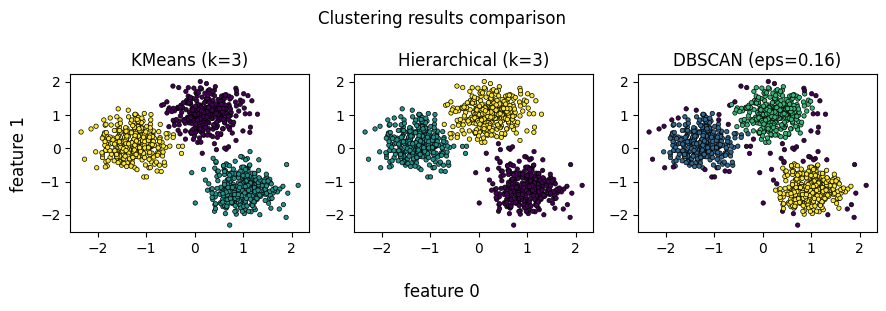

In [8]:
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

fig.suptitle('Clustering results comparison')
fig.supxlabel('feature 0')
fig.supylabel('feature 1')

# KMeans
axes[0].scatter(df['feature_0'], df['feature_1'], c=kmeans_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'KMeans (k={n_clusters})')

# Hierarchical
axes[1].scatter(df['feature_0'], df['feature_1'], c=hierarchical_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical (k={n_clusters})')

# DBSCAN
axes[2].scatter(df['feature_0'], df['feature_1'], c=dbscan_labels, s = 10, edgecolors='black', linewidth=0.5)
axes[2].set_title(f'DBSCAN (eps={eps})')

plt.tight_layout()
plt.show()

#### 1.4.3. Dendrogram (hierarchical clustering only)

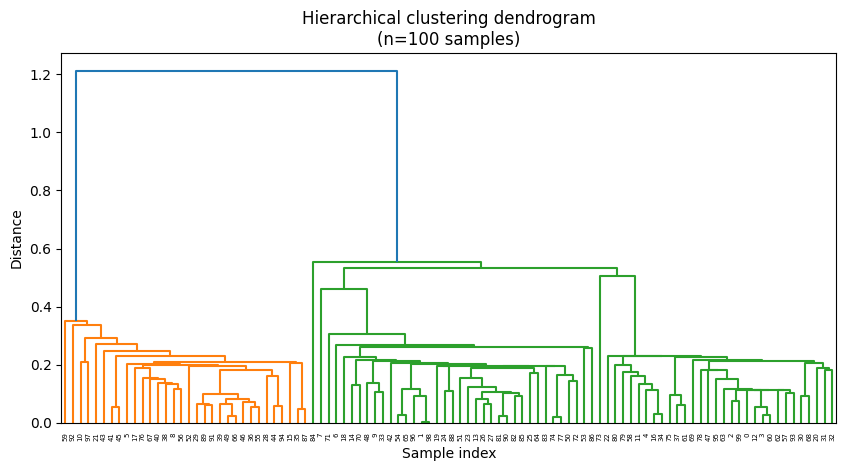

In [9]:
# Create dendrogram
linkage_matrix = linkage(df.iloc[:100])

plt.figure(figsize=(10, 4.8))
dendrogram(linkage_matrix)
plt.title('Hierarchical clustering dendrogram\n(n=100 samples)')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

### 1.5. Determining cluster number

#### 1.5.1. Elbow method

The elbow method helps determine the optimal number of clusters by plotting the within-cluster sum of squares (inertia) for different values of k. The optimal k is at the 'elbow' where the rate of decrease sharply changes.

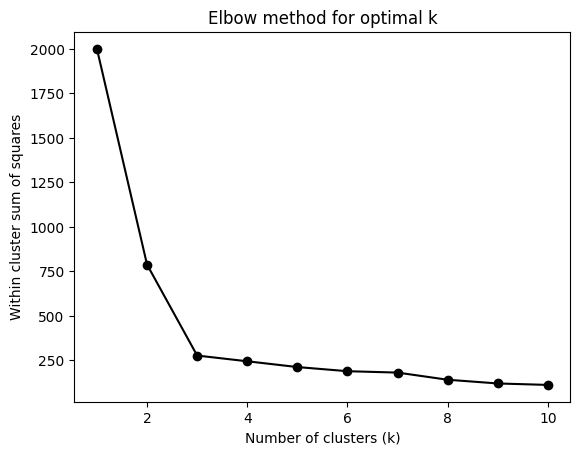

In [10]:
# Calculate inertia for different numbers of clusters
k_range = range(1, 11)
inertias = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=315)
    kmeans_temp.fit(df)
    inertias.append(kmeans_temp.inertia_)

# Plot elbow curve
plt.plot(k_range, inertias, marker='o', color='black')
plt.title('Elbow method for optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within cluster sum of squares')
plt.show()

#### 1.5.2. Silhouette analysis

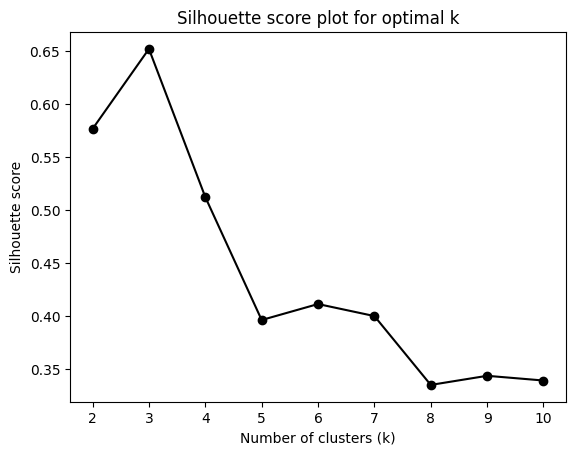

In [11]:
# Calculate silhouette score for different numbers of clusters
k_range = range(2, 11)
silhouette_scores = []

for k in k_range:

    kmeans_temp = KMeans(n_clusters=k, random_state=315)
    labels = kmeans_temp.fit_predict(df)
    silhouette_scores.append(silhouette_score(df, labels))

# Plot silhouette curve
plt.plot(k_range, silhouette_scores, marker='o', color='black')
plt.title('Silhouette score plot for optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.show()

## 2. Dimensionality reduction

### 2.1. High dimensional dataset

In [12]:
# Create high dimensional dataset by multiplying each feature with random noise
# a number of times, results in a set of features that contain the cluster signal
# hidden among noisy features
n_features = 10
noise_range = (-1.25, 1.25)
noise_features = {}

for feature in df.columns:

    for j in range(n_features // len(df.columns)):

        noise = np.random.uniform(low=noise_range[0], high=noise_range[1], size=len(df))
        noise_features[f'{feature}_noise_{j}'] = df[feature] + noise

# Create new dataframe with 10 features
noise_df = pd.DataFrame(noise_features)

print(f'Original dataset shape: {df.shape}')
print(f'High dimensional dataset shape: {noise_df.shape}')
noise_df.head()

Original dataset shape: (1000, 2)
High dimensional dataset shape: (1000, 10)


,feature_0_noise_0,feature_0_noise_1,feature_0_noise_2,feature_0_noise_3,feature_0_noise_4,feature_1_noise_0,feature_1_noise_1,feature_1_noise_2,feature_1_noise_3,feature_1_noise_4
0,-2.048381,-0.085931,-1.137835,0.048630,-1.851583,-0.983986,0.328683,1.038294,-0.600173,-0.879659
1,-0.415348,1.862773,-0.398593,-0.413800,-0.449317,0.455398,1.262306,1.406350,1.542537,0.011551
2,-1.479480,-1.088652,-0.808002,-2.350946,-1.378137,-0.021607,0.374792,-0.730838,1.017682,0.118621
3,-1.380207,-1.208147,0.116601,-0.719665,-1.797849,-0.480232,-0.667684,-0.889463,0.920275,-0.489470
4,-1.344992,-2.845930,-1.429648,-2.594555,-0.431993,0.667687,0.165954,-0.313992,0.571808,0.838824


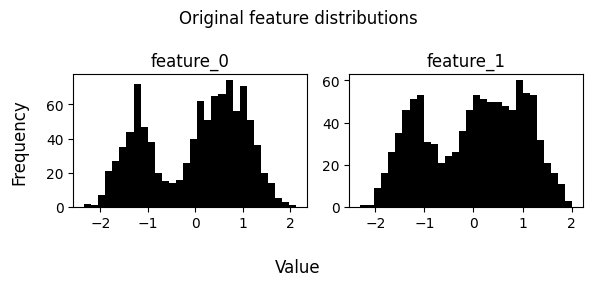

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2.75))

fig.suptitle('Original feature distributions')
fig.supxlabel('Value')
fig.supylabel('Frequency')

# Original data
for i, feature in enumerate(df.columns):
    axs[i].set_title(f'{feature}')
    axs[i].hist(df[feature], bins=30, color='black')

plt.tight_layout()
plt.show()

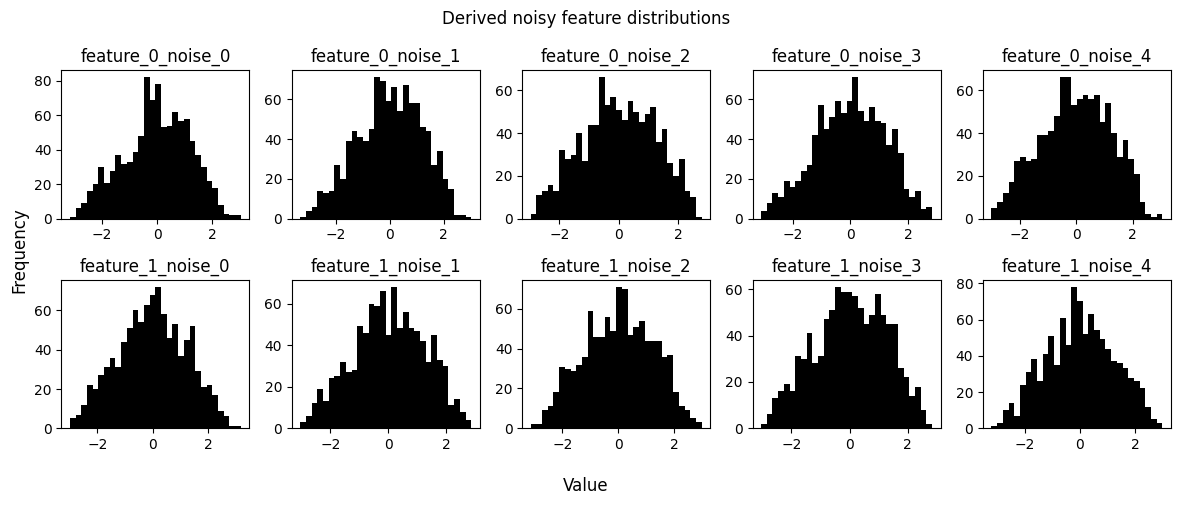

In [14]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
axs = axs.flatten()

fig.suptitle('Derived noisy feature distributions')
fig.supxlabel('Value')
fig.supylabel('Frequency')

# Original data
for i, feature in enumerate(noise_df.columns):
    axs[i].set_title(f'{feature}')
    axs[i].hist(noise_df[feature], bins=30, color='black')

plt.tight_layout()
plt.show()

In [15]:
output_features = 2
scaler = StandardScaler()

### 2.2. PCA

Principal Component Analysis transforms data to a new coordinate system where the greatest variance lies on the first coordinate (first principal component).

Scikit-learn [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) implementation

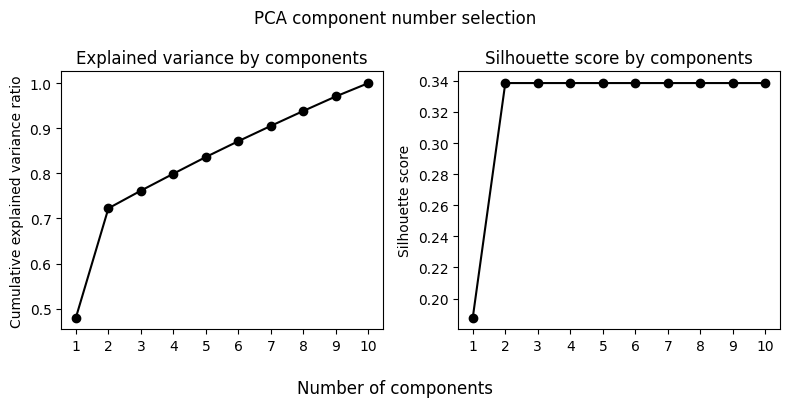

In [16]:
# Evaluate cumulative explained variance across a range of component numbers
comp_range = range(1, 11)
cumulative_variance = []
silhouette_scores = []

for n_comp in comp_range:

    pca_temp = PCA(n_components=n_comp, random_state=315)
    pca_temp.fit(noise_df)
    cumulative_variance.append(np.sum(pca_temp.explained_variance_ratio_))

    kmeans_temp = KMeans(n_clusters=3, random_state=315)
    kmeans_labels_temp = kmeans_temp.fit_predict(pca_temp.transform(noise_df))
    silhouette_scores.append(silhouette_score(noise_df, kmeans_labels_temp))

# Plot cumulative explained variance
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

fig.suptitle('PCA component number selection')
fig.supxlabel('Number of components')

axs[0].set_title('Explained variance by components')
axs[0].plot(comp_range, cumulative_variance, marker='o', color='black')
axs[0].set_ylabel('Cumulative explained variance ratio')
axs[0].set_xticks(comp_range)

axs[1].set_title('Silhouette score by components')
axs[1].plot(comp_range, silhouette_scores, marker='o', color='black')
axs[1].set_ylabel('Silhouette score')
axs[1].set_xticks(comp_range)

plt.tight_layout()
plt.show()

In [17]:
# Apply PCA
pca = PCA(n_components=output_features, random_state=315)
X_pca = pca.fit_transform(noise_df)

pca_df = pd.DataFrame(X_pca, columns=pca.get_feature_names_out())
pca_df.head()

,pca0,pca1
0,1.128470,-2.042808
1,1.454810,1.405447
2,2.363407,-2.123943
3,0.946402,-2.162916
4,3.201961,-2.225119


### 2.3. Feature Agglomeration

Feature Agglomeration uses hierarchical clustering to group similar features together, reducing dimensionality while preserving the structure of the data.

Scikit-learn [FeatureAgglomeration](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.FeatureAgglomeration.html) implementation

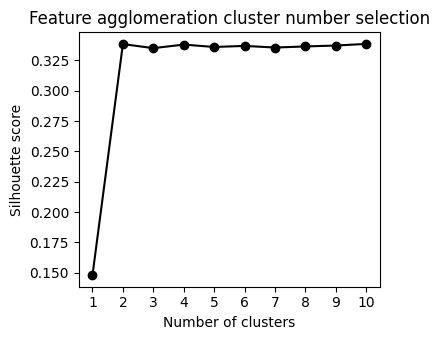

In [18]:
# Evaluate silhouette score across a range of agglomeration cluster numbers
cluster_range = range(1, 11)
silhouette_scores = []

for n_clusters in cluster_range:

    agg_temp = FeatureAgglomeration(n_clusters=n_clusters)
    agg_temp.fit(noise_df)

    kmeans_temp = KMeans(n_clusters=3, random_state=315)
    kmeans_labels_temp = kmeans_temp.fit_predict(agg_temp.transform(noise_df))
    silhouette_scores.append(silhouette_score(noise_df, kmeans_labels_temp))

# Plot cumulative explained variance
plt.figure(figsize=(4, 3.5))
plt.title('Feature agglomeration cluster number selection')
plt.plot(cluster_range, silhouette_scores, marker='o', color='black')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(cluster_range)

plt.tight_layout()
plt.show()

In [19]:
# Apply Feature Agglomeration
fa = FeatureAgglomeration(n_clusters=output_features)
X_fa = fa.fit_transform(noise_df)

# Create FA dataframe
fa_df = pd.DataFrame(X_fa, columns=[f'FA{i+1}' for i in range(output_features)])
fa_df.head()

,FA1,FA2
0,-1.015020,-0.219368
1,0.037143,0.935628
2,-1.421043,0.151730
3,-0.997853,-0.321315
4,-1.729424,0.386056


### 2.4. TruncatedSVD

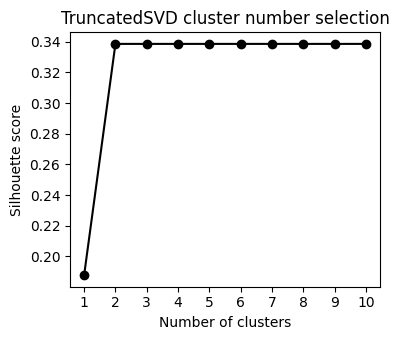

In [20]:
# Evaluate silhouette score across a range of agglomeration cluster numbers
cluster_range = range(1, 11)
silhouette_scores = []

for n_clusters in cluster_range:

    svd_temp = TruncatedSVD(n_components=n_clusters)
    svd_temp.fit(noise_df)

    kmeans_temp = KMeans(n_clusters=3, random_state=315)
    kmeans_labels_temp = kmeans_temp.fit_predict(svd_temp.transform(noise_df))
    silhouette_scores.append(silhouette_score(noise_df, kmeans_labels_temp))

# Plot cumulative explained variance
plt.figure(figsize=(4, 3.5))
plt.title('TruncatedSVD cluster number selection')
plt.plot(cluster_range, silhouette_scores, marker='o', color='black')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(cluster_range)

plt.tight_layout()
plt.show()

In [21]:
# Apply Truncated SVD
svd = TruncatedSVD(n_components=output_features)
X_svd = svd.fit_transform(noise_df)

# Create SVD dataframe
svd_df = pd.DataFrame(X_svd, columns=[f'SVD{i+1}' for i in range(output_features)])
svd_df.head()

,SVD1,SVD2
0,1.173431,-2.030142
1,1.500221,1.418007
2,2.408038,-2.111665
3,0.991178,-2.150325
4,3.245986,-2.213331


### 2.5. t-SNE

t-Distributed Stochastic Neighbor Embedding is a nonlinear dimensionality reduction technique particularly well-suited for visualizing high-dimensional data.

Scikit-learn [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementation

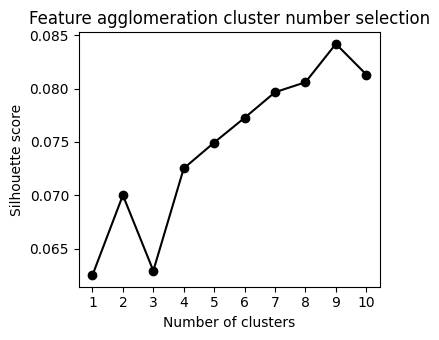

In [22]:
# Evaluate silhouette score across a range of component numbers
components_range = range(1, 11)
silhouette_scores = []

for n_components in components_range:

    tsne_temp = TSNE(n_components=n_components, method='exact', random_state=315)
    kmeans_temp = KMeans(n_clusters=n_clusters, random_state=315)
    kmeans_labels_temp = kmeans_temp.fit_predict(tsne_temp.fit_transform(noise_df))
    silhouette_scores.append(silhouette_score(noise_df, kmeans_labels_temp))

# Plot cumulative explained variance
plt.figure(figsize=(4, 3.5))
plt.title('Feature agglomeration cluster number selection')
plt.plot(components_range, silhouette_scores, marker='o', color='black')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(components_range)

plt.tight_layout()
plt.show()

In [23]:
# Apply t-SNE
tsne = TSNE(n_components=output_features, method='exact', random_state=315)
X_tsne = tsne.fit_transform(noise_df)

# Create t-SNE dataframe
tsne_df = pd.DataFrame(X_tsne, columns=[f'TSNE{i+1}' for i in range(output_features)])
tsne_df.head()

,TSNE1,TSNE2
0,21.018663,-20.136845
1,3.004445,18.033903
2,33.436581,-17.886982
3,28.143726,-23.466967
4,43.425419,1.214504


### 2.6. Dimensionality reduction comparison

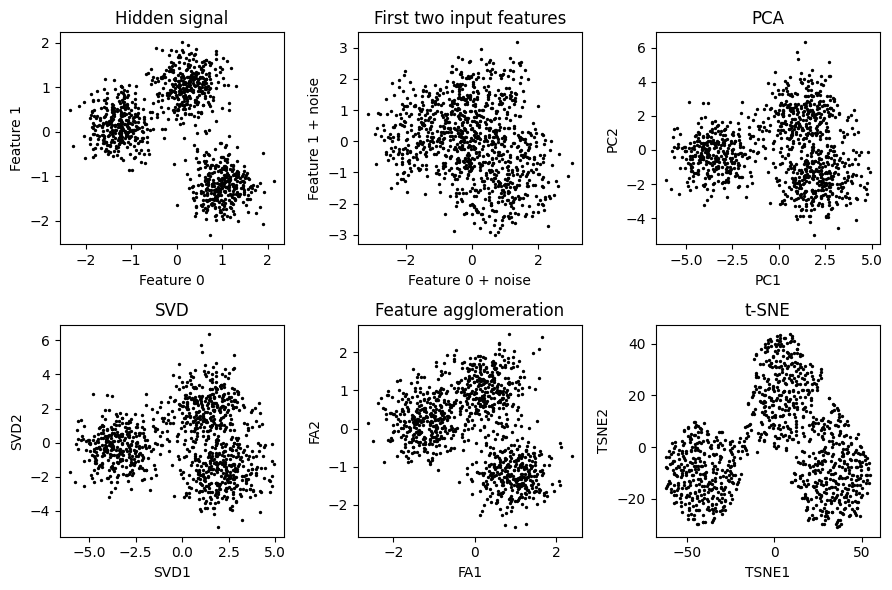

In [24]:
ncols = 3
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))
axes = axes.flatten()

# Input signal
axes[0].set_title('Hidden signal')
axes[0].scatter(df['feature_0'], df['feature_1'], c='black', s=2)
axes[0].set_xlabel('Feature 0')
axes[0].set_ylabel('Feature 1')

# Input features
axes[1].set_title('First two input features')
axes[1].scatter(noise_df['feature_0_noise_0'], noise_df['feature_1_noise_0'], c='black', s=2)
axes[1].set_xlabel('Feature 0 + noise')
axes[1].set_ylabel('Feature 1 + noise')

# PCA
axes[2].set_title('PCA')
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c='black', s=2)
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')

# SVD
axes[3].set_title('SVD')
axes[3].scatter(X_svd[:, 0], X_svd[:, 1], c='black', s=2)
axes[3].set_xlabel('SVD1')
axes[3].set_ylabel('SVD2')

# Feature Agglomeration
axes[4].set_title('Feature agglomeration')
axes[4].scatter(X_fa[:, 0], X_fa[:, 1], c='black', s=2)
axes[4].set_xlabel('FA1')
axes[4].set_ylabel('FA2')

# t-SNE
axes[5].set_title('t-SNE')
axes[5].scatter(X_tsne[:, 0], X_tsne[:, 1], c='black', s=2)
axes[5].set_xlabel('TSNE1')
axes[5].set_ylabel('TSNE2')

plt.tight_layout()
plt.show()

### 2.7. A note about LDA

LDA (linear discriminant analysis) is a supervised algorithms, so it doesn't really fit in this lesson - but if you have labels and want to do dimensionality reduction, it can be a great option!

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_df = noise_df.copy()
lda_df['label'] = kmeans_labels

lda = LinearDiscriminantAnalysis(n_components=2)
lda_features = lda.fit_transform(lda_df.drop(columns='label'), lda_df['label'])
lda_df = pd.DataFrame(lda_features, columns=lda.get_feature_names_out())
lda_df.head()

,lineardiscriminantanalysis0,lineardiscriminantanalysis1
0,1.167487,-1.656829
1,1.262109,1.495803
2,2.336811,-1.786738
3,1.003792,-1.934860
4,3.184479,-1.979708


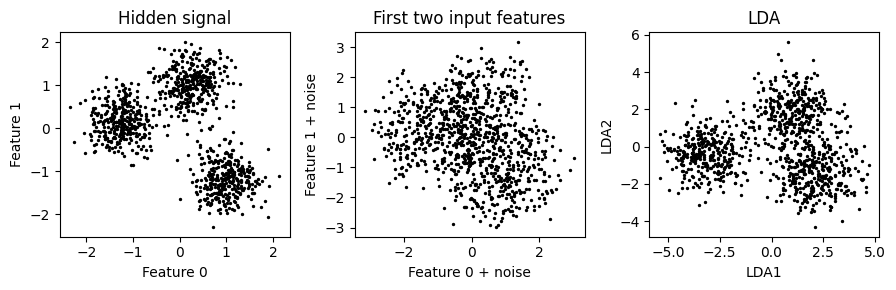

In [26]:
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3, nrows*3))

# Input signal
axes[0].set_title('Hidden signal')
axes[0].scatter(df['feature_0'], df['feature_1'], c='black', s=2)
axes[0].set_xlabel('Feature 0')
axes[0].set_ylabel('Feature 1')

# Input features
axes[1].set_title('First two input features')
axes[1].scatter(noise_df['feature_0_noise_0'], noise_df['feature_1_noise_0'], c='black', s=2)
axes[1].set_xlabel('Feature 0 + noise')
axes[1].set_ylabel('Feature 1 + noise')

# LDA
axes[2].set_title('LDA')
axes[2].scatter(lda_df.values[:, 0], lda_df.values[:, 1], c='black', s=2)
axes[2].set_xlabel('LDA1')
axes[2].set_ylabel('LDA2')

plt.tight_layout()
plt.show()

## 3. Anomaly detection

### 3.1. Dataset

In [27]:
# Add random uniform noise points to original clusters
num_noise_points = 10
noise_points = {}

for feature in df.columns:

    noise_points[feature] = np.random.uniform(
        low=df[feature].mean() - df[feature].std() * 5,
        high=df[feature].mean() + df[feature].std() * 5,
        size=num_noise_points
    )

outlier_df = pd.concat([df, pd.DataFrame(noise_points)], ignore_index=True)

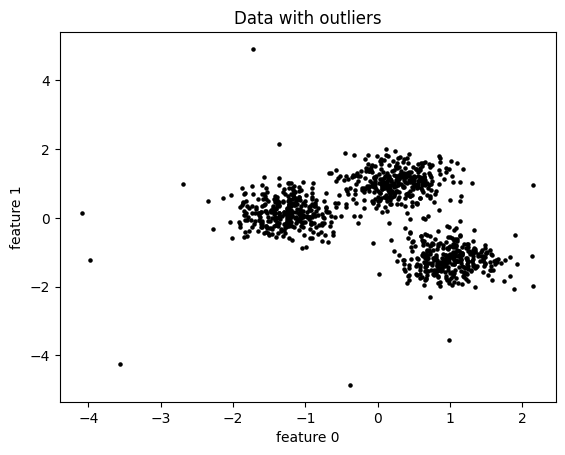

In [28]:
plt.title('Data with outliers')
plt.scatter(outlier_df['feature_0'], outlier_df['feature_1'], s=5, c='black')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

### 3.2. Robust covariance (elliptic envelope)

Robust covariance estimation assumes that the data is Gaussian and learns an ellipse that contains most of the normal data points.

Scikit-learn [EllipticEnvelope](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html) implementation

In [29]:
# Fit Elliptic Envelope
elliptic = EllipticEnvelope(contamination=0.01, random_state=315)
elliptic_labels = elliptic.fit_predict(outlier_df)

# Count outliers
n_outliers = list(elliptic_labels).count(-1)
n_inliers = list(elliptic_labels).count(1)

print(f'Elliptic Envelope found {n_outliers} outliers and {n_inliers} inliers')

Elliptic Envelope found 11 outliers and 999 inliers


### 3.3. One-class SVM

One-class SVM learns a decision boundary around the normal data points using support vector machines.

Scikit-learn [OneClassSVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html) implementation

In [30]:
# Fit One-Class SVM
ocsvm = OneClassSVM(nu=0.01, gamma='auto')
ocsvm_labels = ocsvm.fit_predict(outlier_df)

# Count outliers
n_outliers = list(ocsvm_labels).count(-1)
n_inliers = list(ocsvm_labels).count(1)

print(f'One-Class SVM found {n_outliers} outliers and {n_inliers} inliers')

One-Class SVM found 10 outliers and 1000 inliers


### 3.4. Isolation Forest

Isolation Forest isolates anomalies by randomly selecting features and split values. Anomalies are points that have shorter paths in the tree structure.

Scikit-learn [IsolationForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) implementation

In [31]:
# Fit Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=315)
iso_forest_labels = iso_forest.fit_predict(outlier_df)

# Count outliers
n_outliers = list(iso_forest_labels).count(-1)
n_inliers = list(iso_forest_labels).count(1)

print(f'Isolation Forest found {n_outliers} outliers and {n_inliers} inliers')

Isolation Forest found 11 outliers and 999 inliers


### 3.5. Local Outlier Factor

Local Outlier Factor computes the local density deviation of a data point with respect to its neighbors. Points with substantially lower density than their neighbors are considered outliers.

Scikit-learn [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) implementation

In [32]:
# Fit Local Outlier Factor
lof = LocalOutlierFactor(contamination=0.01)
lof_labels = lof.fit_predict(outlier_df)

# Count outliers
n_outliers = list(lof_labels).count(-1)
n_inliers = list(lof_labels).count(1)

print(f'Local Outlier Factor found {n_outliers} outliers and {n_inliers} inliers')

Local Outlier Factor found 11 outliers and 999 inliers


### 3.6. Anomaly detection comparison

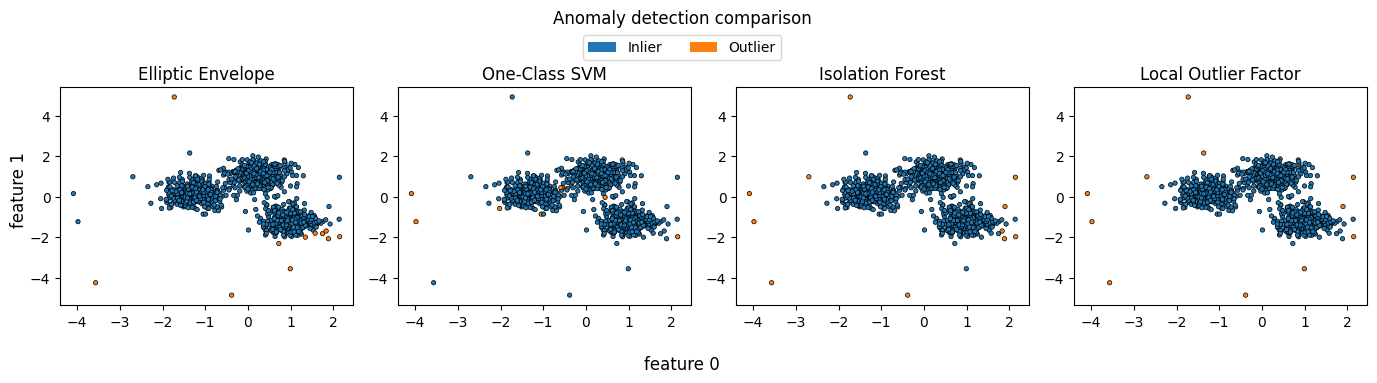

In [33]:
# Define color mapping for outlier detection results
colors = {-1:'#ff7f0e', 1:'#1f77b4'}

ncols = 4
nrows = 1

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*3.5, nrows*3.75))
axes = axes.flatten()

fig.suptitle('Anomaly detection comparison')
fig.supxlabel('feature 0')
fig.supylabel('feature 1')

# Elliptic Envelope
axes[0].set_title('Elliptic Envelope')
axes[0].scatter(outlier_df['feature_0'], outlier_df['feature_1'], c=[colors[label] for label in elliptic_labels], s=10, edgecolors='black', linewidth=0.5)

# One-Class SVM
axes[1].set_title('One-Class SVM')
axes[1].scatter(outlier_df['feature_0'], outlier_df['feature_1'], c=[colors[label] for label in ocsvm_labels], s=10, edgecolors='black', linewidth=0.5)

# Isolation Forest
axes[2].set_title('Isolation Forest')
axes[2].scatter(outlier_df['feature_0'], outlier_df['feature_1'], c=[colors[label] for label in iso_forest_labels], s=10, edgecolors='black', linewidth=0.5)

# Local Outlier Factor
axes[3].set_title('Local Outlier Factor')
axes[3].scatter(outlier_df['feature_0'], outlier_df['feature_1'], c=[colors[label] for label in lof_labels], s=10, edgecolors='black', linewidth=0.5)

# Create custom legend
legend_elements = [
    Patch(facecolor='#1f77b4', label='Inlier'),
    Patch(facecolor='#ff7f0e', label='Outlier')
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 4. Association rule learning

### 4.1. Dataset

In [34]:
basket_df = pd.read_csv('https://gperdrizet.github.io/FSA_devops/assets/data/unit3/market_basket.csv')
basket_df.head()

,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19
0,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,low fat yogurt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
basket_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   item_1   7500 non-null   object
 1   item_2   5746 non-null   object
 2   item_3   4388 non-null   object
 3   item_4   3344 non-null   object
 4   item_5   2528 non-null   object
 5   item_6   1863 non-null   object
 6   item_7   1368 non-null   object
 7   item_8   980 non-null    object
 8   item_9   653 non-null    object
 9   item_10  394 non-null    object
 10  item_11  255 non-null    object
 11  item_12  153 non-null    object
 12  item_13  86 non-null     object
 13  item_14  46 non-null     object
 14  item_15  24 non-null     object
 15  item_16  7 non-null      object
 16  item_17  3 non-null      object
 17  item_18  3 non-null      object
 18  item_19  2 non-null      object
dtypes: object(19)
memory usage: 1.1+ MB


In [36]:
basket = basket_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
basket[:5]

[['burgers', 'meatballs', 'eggs'],
 ['chutney'],
 ['turkey', 'avocado'],
 ['mineral water', 'milk', 'energy bar', 'whole wheat rice', 'green tea'],
 ['low fat yogurt']]

### 4.2. Encode items

In [37]:
encoder = TransactionEncoder()
encoder.fit(basket)
transactions = encoder.transform(basket)
basket_df = pd.DataFrame(transactions, columns=encoder.columns_)
basket_df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 4.3. Find association rules with Apriori

In [38]:
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)
frequent_itemsets.reset_index(drop=True, inplace=True)
print(f'Number of frequent itemsets found: {len(frequent_itemsets)}')
frequent_itemsets.head()

Number of frequent itemsets found: 259


,support,itemsets
0,0.238267,(mineral water)
1,0.179733,(eggs)
2,0.174133,(spaghetti)
3,0.170933,(french fries)
4,0.163867,(chocolate)


In [39]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules.sort_values(by='confidence', ascending=False, inplace=True)
rules.reset_index(drop=True, inplace=True)

print(f'Number of association rules found: {len(rules)}')
rules.head()

Number of association rules found: 162


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,"(ground beef, eggs)",(mineral water),0.020000,0.238267,0.010133,0.506667,2.126469,1.0,0.005368,1.544054,0.540548,0.040838,0.352354,0.274598
1,"(ground beef, milk)",(mineral water),0.022000,0.238267,0.011067,0.503030,2.111207,1.0,0.005825,1.532756,0.538177,0.044409,0.347580,0.274738
2,"(ground beef, chocolate)",(mineral water),0.023067,0.238267,0.010933,0.473988,1.989319,1.0,0.005437,1.448130,0.509058,0.043663,0.309454,0.259938
3,"(frozen vegetables, milk)",(mineral water),0.023600,0.238267,0.011067,0.468927,1.968075,1.0,0.005444,1.434328,0.503778,0.044125,0.302809,0.257687
4,(soup),(mineral water),0.050533,0.238267,0.023067,0.456464,1.915771,1.0,0.011026,1.401441,0.503458,0.086804,0.286449,0.276637
